<a href="https://colab.research.google.com/github/abksyed/EVA4/blob/master/S5/EVA4_S5_Assignment_iter01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Statements

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torchvision import datasets, transforms

# Targets

**Overall Target to Acheive**
 

1.   99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement)
2.   Less than or equal to 15 Epochs
3.   Less than 10000 Parameters

*Target for this Iteration:*


1.   Build the Basic Model
2.   Import Data and Transform
3.   Set up Training and Testing methods

#Raw Data Statistics

In [2]:
#Getting to know Data
data = datasets.MNIST('./data', train= True, transform= transforms.Compose([transforms.ToTensor(),]), download= True)

exp = data.data
exp = data.transform(exp.numpy())

print('Train Statistics')
print(' - Numpy Shape:', data.data.cpu().numpy().shape)
print(' - Tensor Shape:', data.data.size())
print(' - min:', torch.min(exp))
print(' - max:', torch.max(exp))
print(' - mean:', torch.mean(exp))
print(' - std:', torch.std(exp))
print(' - var:', torch.var(exp))

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


#Transforming Raw Data to Normalized Data

In [0]:
#Transforming Data (Normalizing to mean=1, std= 0)
train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1311,), (0.3081,))
]
)

test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1311,),(0.3081,))
])

#Creating Train/Test Split

In [0]:
#Getting Train and Test Data
train = datasets.MNIST('./data', train= True, transform= train_transform)
test = datasets.MNIST('./data', train= False, transform= test_transform)

#Dataloader Arguments & Test/Train Dataloaders

In [72]:
seed = 1

#CUDA Availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

#For Reproducibility
torch.manual_seed(seed)

if cuda:
    torch.cuda.manual_seed(seed)

dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory= True) if cuda else dict(shuffle= True, batch_size=64)

#Train Dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#Test Dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: torch.Size([28, 60000, 28])
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4255)
 - max: tensor(2.8202)
 - mean: tensor(0.0004)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


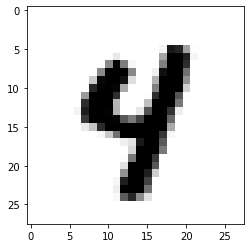

In [80]:
#Testing Normalized Data Statistics

train_numpy = train.train_data
train_numpy = train.transform(train_numpy.numpy())

print('[Train]')
print(' - Numpy Shape:', train_numpy.shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_numpy))
print(' - max:', torch.max(train_numpy))
print(' - mean:', torch.mean(train_numpy))
print(' - std:', torch.std(train_numpy))
print(' - var:', torch.var(train_numpy))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

#Viewing Sample Images in Dataset

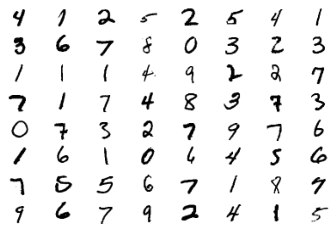

In [86]:
figure = plt.figure()
num_of_images = 64
for index in range(0, num_of_images):
    plt.subplot(8, 8, index+1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

#**THE MODEL**

In [0]:
class Net(nn.Module):

  def __init__(self):

    super(Net, self).__init__()

    #Input Block - Input= 28
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels= 1, out_channels= 8, kernel_size= 3, padding= 1, bias= False),
        F.relu()
    ) #Output= 28 / ReceptiveField= 3

    #Convolution Block - Input= 28
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size= 3, padding= 1, bias= False),
        F.relu()
    ) #Output= 28 / ReceptiveField= 5

    #Max Pooling
    self.pool1 = nn.MaxPool2d(2) 
    #Output= 14 / ReceptiveField= 6

    